In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from pyampd.ampd import find_peaks
import joblib


In [ ]:
PPG_datas = []
ABP_datas = []
ECG_datas = []
i = 0
for name in glob.glob('./dataset/*.csv'):
    raw_training_data = pd.read_csv(name, header=None)
    raw_training_data = np.array(raw_training_data)
    #print(raw_training_data.shape)
    PPG_data = raw_training_data[0].reshape(-1)
    ABP_data = raw_training_data[1].reshape(-1)
    ECG_data = raw_training_data[2].reshape(-1)
    
    PPG_datas.append(PPG_data)
    ABP_datas.append(ABP_data)
    ECG_datas.append(ECG_data)
    i = i + 1
    print(i)
#     if (i == 100):
#         break

PPG_datas = np.array(PPG_datas)
ABP_datas = np.array(ABP_datas)
ECG_datas = np.array(ECG_datas)

#raw_training_data.head()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [ ]:
print(PPG_datas.shape)

In [4]:
from sklearn.decomposition import PCA

def generate_whole_based_vector(X):
    vector = np.zeros(4 * SAMPLE_FREQ)
    vector[:len(X)] = X
    return vector
    

In [5]:
SAMPLE_FREQ = 125

In [6]:
#generate dataset
whole_based_vectors = []
SBP_data = []
DBP_data = []
MAP_data = []

for j in range(len(PPG_datas)):
    sec_15 = 15*SAMPLE_FREQ
    PPG_data = PPG_datas[j]
    ABP_data = ABP_datas[j]
    PPG_peaks = find_peaks(PPG_data, scale=SAMPLE_FREQ)
    for i in range(2, PPG_peaks.shape[0]):
        X = PPG_data[PPG_peaks[i-1]:PPG_peaks[i]]
        if(len(X) < SAMPLE_FREQ):
            whole_based_vector = generate_whole_based_vector(X)

            SBP = np.max(ABP_data[PPG_peaks[i-1]:PPG_peaks[i-1]+sec_15])
            DBP = np.min(ABP_data[PPG_peaks[i-1]:PPG_peaks[i-1]+sec_15])
            MAP = SBP/3 + 2*DBP/3

            whole_based_vectors.append(whole_based_vector)
            SBP_data.append(SBP)
            DBP_data.append(DBP)
            MAP_data.append(MAP)
        


In [7]:
whole_based_vectors = np.array(whole_based_vectors)
SBP_data = np.array(SBP_data)
DBP_data = np.array(DBP_data)
MAP_data = np.array(MAP_data)
print(whole_based_vectors.shape)
print(SBP_data.shape)

(196625, 500)
(196625,)


In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=43)
pca_whole_based_vectors = pca.fit_transform(whole_based_vectors)

print(pca_whole_based_vectors.shape)


(196625, 43)


Text(0.5, 1.0, 'whole based vector after PCA')

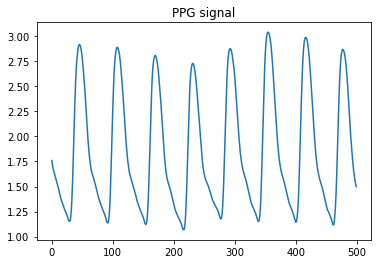

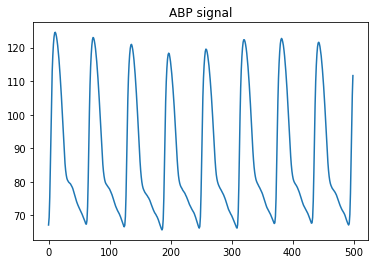

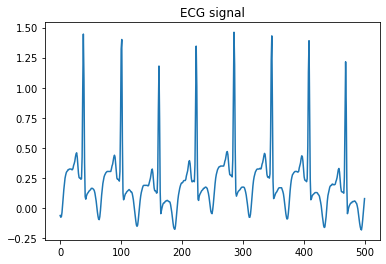

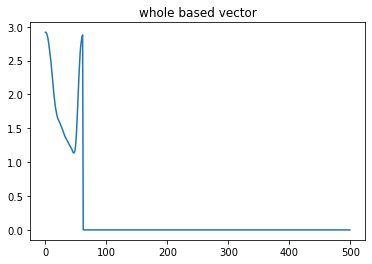

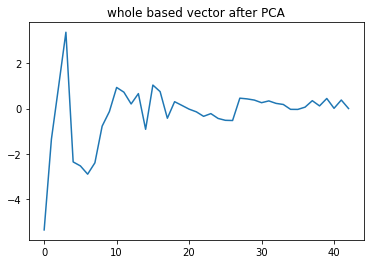

In [9]:
fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(PPG_datas[0][:500])), PPG_datas[0][:500])
plt.title('PPG signal')

fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(ABP_datas[0][:500])), ABP_datas[0][:500])
plt.title('ABP signal')

fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(ECG_datas[0][:500])), ECG_datas[0][:500])
plt.title('ECG signal')

fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(whole_based_vectors[0])), whole_based_vectors[0])
plt.title('whole based vector')

fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(pca_whole_based_vectors[0])), pca_whole_based_vectors[0])
plt.title('whole based vector after PCA')

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, SBP_train, SBP_test, DBP_train, DBP_test, MAP_train, MAP_test = train_test_split(
                                            pca_whole_based_vectors, SBP_data, DBP_data, MAP_data, test_size=0.1, random_state=42)

In [11]:
def AAMI_standard(predict, test):
    total = len(predict)
    ME = np.mean(predict - test)
    MAE = np.mean(np.abs(predict-test))
    SD = np.std(predict-test)
    
    return total, ME, MAE, SD
    
def BHS_standard(predict, test):
    total = len(predict)
    mm5 = np.sum(np.abs(predict-test)<=5)
    mm10 = np.sum(np.abs(predict-test)<=10)
    mm15 = np.sum(np.abs(predict-test)<=15)
    return total, mm5, mm10, mm15

In [12]:
from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import GridSearchCV
# parameters = {'max_depth':[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]}
# clf = GridSearchCV(DecisionTreeRegressor(), parameters)
# clf.fit(x_train, SBP_train)

dtr_SBP = DecisionTreeRegressor(max_depth=10)
print('start fitting...')
dtr_SBP.fit(x_train, SBP_train)
print('finish fitting...')
dtr_SBP_predict = dtr_SBP.predict(x_test)
print('finish predicting...')

dtr_DBP = DecisionTreeRegressor(max_depth=10)
print('start fitting...')
dtr_DBP.fit(x_train, DBP_train)
print('finish fitting...')
dtr_DBP_predict = dtr_DBP.predict(x_test)
print('finish predicting...')

dtr_MAP = DecisionTreeRegressor(max_depth=10)
print('start fitting...')
dtr_MAP.fit(x_train, MAP_train)
print('finish fitting...')
dtr_MAP_predict = dtr_MAP.predict(x_test)
print('finish predicting...')



start fitting...
finish fitting...
finish predicting...
start fitting...
finish fitting...
finish predicting...
start fitting...
finish fitting...
finish predicting...


In [13]:
print('Decision Tree Regressor')

total, ME, MAE, SD = AAMI_standard(dtr_SBP_predict, SBP_test)
print()
print()
print('----------------SBP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(dtr_SBP_predict, SBP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

total, ME, MAE, SD = AAMI_standard(dtr_DBP_predict, DBP_test)
print()
print()
print('----------------DBP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(dtr_DBP_predict, DBP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

total, ME, MAE, SD = AAMI_standard(dtr_MAP_predict, MAP_test)
print()
print()
print('----------------MAP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(dtr_MAP_predict, MAP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

Decision Tree Regressor


----------------SBP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
0.104         12.952         17.724          19663

-------------BHS standard------------
<5mmHg        <10mmHg        <15mmHg        total
6288            10393           13185          19663
31.979%        52.856%       67.055%         19663


----------------DBP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
0.077         5.708         8.647          19663

-------------BHS standard------------
<5mmHg        <10mmHg        <15mmHg        total
11812            16518           18387          19663
60.072%        84.005%       93.511%         19663


----------------MAP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
0.016         7.046         9.708          19663

-------------BHS standard------------
<5mmHg        <10mmH

In [14]:
print('Decision Tree Regressor')

dtr_SBP_cc= np.corrcoef(dtr_SBP_predict, SBP_test)
dtr_DBP_cc= np.corrcoef(dtr_DBP_predict, DBP_test)
dtr_MAP_cc= np.corrcoef(dtr_MAP_predict, MAP_test)
print()
print()
print('------------Correlation Coefficient-------------')
print()
print('SBP: %.3f' % (dtr_SBP_cc[0, 1]))
print()
print('DBP: %.3f' % (dtr_DBP_cc[0, 1]))
print()
print('MAP: %.3f' % (dtr_MAP_cc[0, 1]))


Decision Tree Regressor


------------Correlation Coefficient-------------

SBP: 0.601

DBP: 0.540

MAP: 0.546


In [32]:
joblib.dump(dtr_SBP, './model/dtr_SBP.model')
joblib.dump(dtr_DBP, './model/dtr_DBP.model')
joblib.dump(dtr_MAP, './model/dtr_MAP.model')

['./model/dtr_MAP.model']

In [15]:
#from sklearn.svm import LinearSVR
from sklearn.svm import SVR
# from sklearn.model_selection import GridSearchCV
# parameters = {'max_depth':[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]}
# clf = GridSearchCV(DecisionTreeRegressor(), parameters)
# clf.fit(x_train, SBP_train)

# svr_SBP = LinearSVR(max_iter=10000)
svr_SBP = SVR()
print('start fitting...')
svr_SBP.fit(x_train, SBP_train)
print('finish fitting...')
svr_SBP_predict = svr_SBP.predict(x_test)
print('finish predicting...')

# svr_DBP = LinearSVR(max_iter=10000)
svr_DBP = SVR()
print('start fitting...')
svr_DBP.fit(x_train, DBP_train)
print('finish fitting...')
svr_DBP_predict = svr_DBP.predict(x_test)
print('finish predicting...')

# svr_MAP = LinearSVR(max_iter=10000)
svr_MAP = SVR()
print('start fitting...')
svr_MAP.fit(x_train, MAP_train)
print('finish fitting...')
svr_MAP_predict = svr_MAP.predict(x_test)
print('finish predicting...')


start fitting...
finish fitting...
finish predicting...
start fitting...
finish fitting...
finish predicting...
start fitting...
finish fitting...
finish predicting...


In [16]:
print('Support Vector Regression')

total, ME, MAE, SD = AAMI_standard(svr_SBP_predict, SBP_test)
print()
print()
print('----------------SBP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(svr_SBP_predict, SBP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

total, ME, MAE, SD = AAMI_standard(svr_DBP_predict, DBP_test)
print()
print()
print('----------------DBP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(svr_DBP_predict, DBP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

total, ME, MAE, SD = AAMI_standard(svr_MAP_predict, MAP_test)
print()
print()
print('----------------MAP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(svr_MAP_predict, MAP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

Support Vector Regression


----------------SBP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
0.174         13.358         17.761          19663

-------------BHS standard------------
<5mmHg        <10mmHg        <15mmHg        total
5712            9773           12774          19663
29.049%        49.702%       64.965%         19663


----------------DBP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
-1.312         5.816         9.002          19663

-------------BHS standard------------
<5mmHg        <10mmHg        <15mmHg        total
12031            16447           18302          19663
61.186%        83.644%       93.078%         19663


----------------MAP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
-0.647         7.099         9.759          19663

-------------BHS standard------------
<5mmHg        <10

In [17]:
print('Support Vector Regression')

svr_SBP_cc= np.corrcoef(svr_SBP_predict, SBP_test)
svr_DBP_cc= np.corrcoef(svr_DBP_predict, DBP_test)
svr_MAP_cc= np.corrcoef(svr_MAP_predict, MAP_test)
print()
print()
print('------------Correlation Coefficient-------------')
print()
print('SBP: %.3f' % (svr_SBP_cc[0, 1]))
print()
print('DBP: %.3f' % (svr_DBP_cc[0, 1]))
print()
print('MAP: %.3f' % (svr_MAP_cc[0, 1]))

Support Vector Regression


------------Correlation Coefficient-------------

SBP: 0.598

DBP: 0.480

MAP: 0.539


In [31]:
joblib.dump(svr_SBP, './model/svr_SBP.model')
joblib.dump(svr_DBP, './model/svr_DBP.model')
joblib.dump(svr_MAP, './model/svr_MAP.model')

['./model/svr_MAP.model']

In [18]:
from sklearn.ensemble import AdaBoostRegressor

abr_SBP = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, learning_rate=0.1, loss='exponential')
print('start fitting...')
abr_SBP.fit(x_train, SBP_train)
print('finish fitting...')
abr_SBP_predict = abr_SBP.predict(x_test)
print('finish predicting...')

abr_DBP = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, learning_rate=0.1, loss='exponential')
print('start fitting...')
abr_DBP.fit(x_train, DBP_train)
print('finish fitting...')
abr_DBP_predict = abr_DBP.predict(x_test)
print('finish predicting...')

abr_MAP = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, learning_rate=0.1, loss='exponential')
print('start fitting...')
abr_MAP.fit(x_train, MAP_train)
print('finish fitting...')
abr_MAP_predict = abr_MAP.predict(x_test)
print('finish predicting...')

start fitting...
finish fitting...
finish predicting...
start fitting...
finish fitting...
finish predicting...
start fitting...
finish fitting...
finish predicting...


In [19]:
print('AdaBoost Regression')

total, ME, MAE, SD = AAMI_standard(abr_SBP_predict, SBP_test)
print()
print()
print('----------------SBP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(abr_SBP_predict, SBP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

total, ME, MAE, SD = AAMI_standard(abr_DBP_predict, DBP_test)
print()
print()
print('----------------DBP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(abr_DBP_predict, DBP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

total, ME, MAE, SD = AAMI_standard(abr_MAP_predict, MAP_test)
print()
print()
print('----------------MAP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(abr_MAP_predict, MAP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

AdaBoost Regression


----------------SBP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
-0.219         7.340         12.815          19663

-------------BHS standard------------
<5mmHg        <10mmHg        <15mmHg        total
12176            15198           16648          19663
61.923%        77.292%       84.667%         19663


----------------DBP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
-0.343         3.536         6.568          19663

-------------BHS standard------------
<5mmHg        <10mmHg        <15mmHg        total
15531            18013           18967          19663
78.986%        91.609%       96.460%         19663


----------------MAP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
-0.197         3.914         6.849          19663

-------------BHS standard------------
<5mmHg        <10mmHg

In [20]:
print('AdaBoost Regression')

abr_SBP_cc= np.corrcoef(abr_SBP_predict, SBP_test)
abr_DBP_cc= np.corrcoef(abr_DBP_predict, DBP_test)
abr_MAP_cc= np.corrcoef(abr_MAP_predict, MAP_test)
print()
print()
print('------------Correlation Coefficient-------------')
print()
print('SBP: %.3f' % (abr_SBP_cc[0, 1]))
print()
print('DBP: %.3f' % (abr_DBP_cc[0, 1]))
print()
print('MAP: %.3f' % (abr_MAP_cc[0, 1]))

AdaBoost Regression


------------Correlation Coefficient-------------

SBP: 0.816

DBP: 0.769

MAP: 0.807


In [30]:
joblib.dump(abr_SBP, './model/abr_SBP.model')
joblib.dump(abr_DBP, './model/abr_DBP.model')
joblib.dump(abr_MAP, './model/abr_MAP.model')

['./model/abr_MAP.model']

In [21]:
from sklearn.ensemble import RandomForestRegressor

rfr_SBP = RandomForestRegressor()
print('start fitting...')
rfr_SBP.fit(x_train, SBP_train)
print('finish fitting...')
rfr_SBP_predict = rfr_SBP.predict(x_test)
print('finish predicting...')

rfr_DBP = RandomForestRegressor()
print('start fitting...')
rfr_DBP.fit(x_train, DBP_train)
print('finish fitting...')
rfr_DBP_predict = rfr_DBP.predict(x_test)
print('finish predicting...')

rfr_MAP = RandomForestRegressor()
print('start fitting...')
rfr_MAP.fit(x_train, MAP_train)
print('finish fitting...')
rfr_MAP_predict = rfr_MAP.predict(x_test)
print('finish predicting...')

start fitting...
finish fitting...
finish predicting...
start fitting...
finish fitting...
finish predicting...
start fitting...
finish fitting...
finish predicting...


In [22]:
print('Random Forest Regression')

total, ME, MAE, SD = AAMI_standard(rfr_SBP_predict, SBP_test)
print()
print()
print('----------------SBP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(rfr_SBP_predict, SBP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

total, ME, MAE, SD = AAMI_standard(rfr_DBP_predict, DBP_test)
print()
print()
print('----------------DBP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(rfr_DBP_predict, DBP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

total, ME, MAE, SD = AAMI_standard(rfr_MAP_predict, MAP_test)
print()
print()
print('----------------MAP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(rfr_MAP_predict, MAP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

Random Forest Regression


----------------SBP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
0.028         8.423         13.014          19663

-------------BHS standard------------
<5mmHg        <10mmHg        <15mmHg        total
10195            14174           16203          19663
51.849%        72.085%       82.403%         19663


----------------DBP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
0.218         4.030         6.563          19663

-------------BHS standard------------
<5mmHg        <10mmHg        <15mmHg        total
14504            17864           18972          19663
73.763%        90.851%       96.486%         19663


----------------MAP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
0.109         4.500         6.984          19663

-------------BHS standard------------
<5mmHg        <10mm

In [23]:
print('Random Forest Regression')

rfr_SBP_cc= np.corrcoef(rfr_SBP_predict, SBP_test)
rfr_DBP_cc= np.corrcoef(rfr_DBP_predict, DBP_test)
rfr_MAP_cc= np.corrcoef(rfr_MAP_predict, MAP_test)
print()
print()
print('------------Correlation Coefficient-------------')
print()
print('SBP: %.3f' % (rfr_SBP_cc[0, 1]))
print()
print('DBP: %.3f' % (rfr_DBP_cc[0, 1]))
print()
print('MAP: %.3f' % (rfr_MAP_cc[0, 1]))

Random Forest Regression


------------Correlation Coefficient-------------

SBP: 0.810

DBP: 0.770

MAP: 0.799


In [29]:
joblib.dump(rfr_SBP, './model/rfr_SBP.model')
joblib.dump(rfr_DBP, './model/rfr_DBP.model')
joblib.dump(rfr_MAP, './model/rfr_MAP.model')

['./model/rfr_MAP.model']

In [24]:
print(clf.best_params_)
SBP_predict = clf.predict(x_test)
print(np.corrcoef(SBP_predict, SBP_test))

NameError: name 'clf' is not defined

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.plot(range(30), SBP_test[:30])
ax.plot(range(30), SBP_predict[:30])
plt.title('PPG')

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
 'n_estimators': [100, 500],
 'learning_rate' : [0.001,0.005,0.01,0.05,0.1],
 'loss' : ['linear', 'square', 'exponential']
 }

pre_gs_inst = RandomizedSearchCV(AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10)),
 param_distributions = param_dist,
 cv=3,
 n_iter = 10,
 n_jobs=-1)

pre_gs_inst.fit(x_train[0:3000], SBP_train[0:3000])

In [ ]:
print(pre_gs_inst.best_params_)

In [ ]:
predict = abr_MAP.predict(x_train)
total, ME, MAE, SD = AAMI_standard(predict, MAP_train)
print()
print()
print('----------------SBP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(predict, MAP_train)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))
